In [2]:
import boilerplate

import pyrtl
from pyrtl import *

import z3

## Verifying a Boolean circuit

In [2]:
reset_working_block()

_r = [Input(bitwidth=2, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=3, name="out")

r = [[_r[0][0], _r[0][1]], [_r[1][0], _r[1][1]]]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

out <<= concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0])

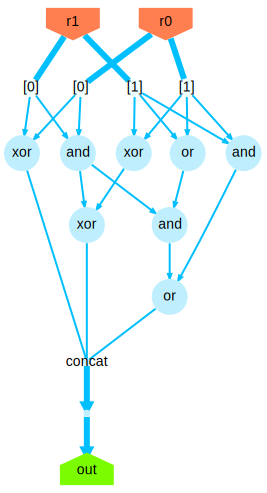

In [3]:
working_block()

In [4]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])


s (1,) [('r0', 2)] [('tmp1', 1)]
s (0,) [('r0', 2)] [('tmp0', 1)]
s (0,) [('r1', 2)] [('tmp2', 1)]
s (1,) [('r1', 2)] [('tmp3', 1)]
|  [('tmp1', 1), ('tmp3', 1)] [('tmp5', 1)]
^  [('tmp1', 1), ('tmp3', 1)] [('tmp9', 1)]
&  [('tmp1', 1), ('tmp3', 1)] [('tmp7', 1)]
^  [('tmp0', 1), ('tmp2', 1)] [('tmp11', 1)]
&  [('tmp0', 1), ('tmp2', 1)] [('tmp4', 1)]
^  [('tmp9', 1), ('tmp4', 1)] [('tmp10', 1)]
&  [('tmp4', 1), ('tmp5', 1)] [('tmp6', 1)]
|  [('tmp6', 1), ('tmp7', 1)] [('tmp8', 1)]
c  [('tmp8', 1), ('tmp10', 1), ('tmp11', 1)] [('tmp12', 3)]
w  [('tmp12', 3)] [('out', 3)]


#### Verifying
_Following is a manual translation of the circuit into a Boolean formula._

In [5]:
from z3 import BitVec, BV2Int

_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [6]:
res = s.check([z3.Not(BV2Int(_r[0]) + BV2Int(_r[1]) == BV2Int(out))])
res

unsat

_Implement a function_ `net_to_smt` _that will do the same (or equivalent) translation automatically._

In [6]:
wires, ops, assertions = net_to_smt(wb)

s = z3.Solver()
for phi in assertions:
    print(phi)
    s.add(phi)

tmp1 == Extract(1, 1, r0)
tmp0 == Extract(0, 0, r0)
tmp2 == Extract(0, 0, r1)
tmp3 == Extract(1, 1, r1)
tmp5 == tmp1 | tmp3
tmp9 == tmp1 ^ tmp3
tmp7 == tmp1 & tmp3
tmp11 == tmp0 ^ tmp2
tmp4 == tmp0 & tmp2
tmp10 == tmp9 ^ tmp4
tmp6 == tmp4 & tmp5
tmp8 == tmp6 | tmp7
tmp12 == Concat(Concat(tmp8, tmp10), tmp11)
out == tmp12


In [7]:
res = s.check([z3.Not(BV2Int(wires.lookup('r0')) + BV2Int(wires.lookup('r1')) ==
               BV2Int(wires.lookup('out')))])
res

unsat

In [8]:
s.model() if res == z3.sat else None

## Verify something with memory?

In [7]:
reset_working_block()

sp = Register(bitwidth=3, name='sp')
mem = MemBlock(bitwidth=3, addrwidth=3, name='mem', max_write_ports=2)

mem[sp] <<= (mem[sp] + 1)[:3]
mem[0] <<= 0
sp.next <<= sp + 1

In [8]:
sim_trace = pyrtl.SimulationTrace()
sim = pyrtl.Simulation(tracer=sim_trace)
for cycle in range(14):
    sim.step({})

sim_trace.render_trace()

<IPython.core.display.Javascript object>

In [9]:
sim.inspect_mem(mem)

{0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 1}

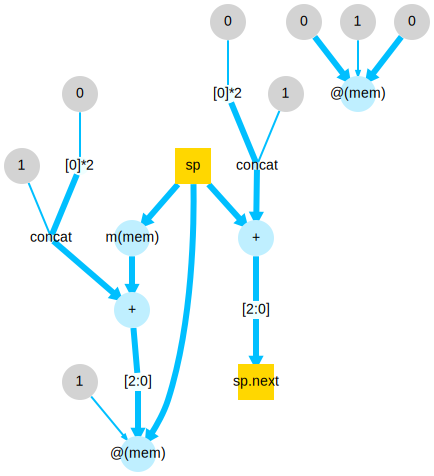

In [11]:
working_block()

In [12]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

s (0, 0) [('const_1_0', 1)] [('tmp1', 2)]
m (0, <pyrtl.memory.MemBlock object at 0x1036c4970>) [('sp', 3)] [('tmp0', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x1036c4970>) [('const_4_0', 3), ('const_6_0', 3), ('const_5_1', 1)] []
s (0, 0) [('const_8_0', 1)] [('tmp5', 2)]
c  [('tmp1', 2), ('const_0_1', 1)] [('tmp2', 3)]
+  [('tmp0', 3), ('tmp2', 3)] [('tmp3', 4)]
c  [('tmp5', 2), ('const_7_1', 1)] [('tmp6', 3)]
+  [('sp', 3), ('tmp6', 3)] [('tmp7', 4)]
s (0, 1, 2) [('tmp3', 4)] [('tmp4', 3)]
s (0, 1, 2) [('tmp7', 4)] [('tmp8', 3)]
r  [('tmp8', 3)] [('sp', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x1036c4970>) [('sp', 3), ('tmp4', 3), ('const_2_1', 1)] []


In [13]:
list(wb)

[LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x103726920>,), dests=(<pyrtl.wire.WireVector object at 0x1037268f0>,)),
 LogicNet(op='m', op_param=(0, <pyrtl.memory.MemBlock object at 0x1036c4970>), args=(<pyrtl.wire.Register object at 0x1037248e0>,), dests=(<pyrtl.wire.WireVector object at 0x103724370>,)),
 LogicNet(op='@', op_param=(0, <pyrtl.memory.MemBlock object at 0x1036c4970>), args=(<pyrtl.wire.Const object at 0x1037251b0>, <pyrtl.wire.Const object at 0x103726b90>, <pyrtl.wire.Const object at 0x103724430>), dests=()),
 LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x103724c70>,), dests=(<pyrtl.wire.WireVector object at 0x103727df0>,)),
 LogicNet(op='c', op_param=None, args=(<pyrtl.wire.WireVector object at 0x1037268f0>, <pyrtl.wire.Const object at 0x103726aa0>), dests=(<pyrtl.wire.WireVector object at 0x103724f40>,)),
 LogicNet(op='+', op_param=None, args=(<pyrtl.wire.WireVector object at 0x103724370>, <pyrtl.wire.WireVector object at

In [14]:
# an example for a Z3 function for handling arrays
z3.K??

Signature: z3.K(dom, v)
Source:   
def K(dom, v):
    """Return a Z3 constant array expression.

    >>> a = K(IntSort(), 10)
    >>> a
    K(Int, 10)
    >>> a.sort()
    Array(Int, Int)
    >>> i = Int('i')
    >>> a[i]
    K(Int, 10)[i]
    >>> simplify(a[i])
    10
    """
    if z3_debug():
        _z3_assert(is_sort(dom), "Z3 sort expected")
    ctx = dom.ctx
    if not is_expr(v):
        v = _py2expr(v, ctx)
    return ArrayRef(Z3_mk_const_array(ctx.ref(), dom.ast, v.as_ast()), ctx)
File:      ~/var/ext/z3/head/build/python/z3/z3.py
Type:      function


In [15]:
# careful not to override the names `sp` and `mem` from before
# (the register and memory block, respectively)!
vsp = z3.BitVec('sp', 3)
vmem = z3.Array('mem', z3.BitVecSort(3), z3.BitVecSort(3))

state_vars = [vsp, vmem]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

rules = [
    Inv(0, z3.K(z3.BitVecSort(3), z3.BitVecVal(0, 3))),
    z3.Implies(Inv(vsp, vmem), Inv(vsp + 1, z3.Store(vmem, vsp, vmem[vsp] + 1))),
    z3.Implies(Inv(vsp, vmem), z3.Or(vmem[1] == vmem[2], vmem[1] == vmem[2] + 1))
]

In [16]:
from verification_utils import CHCs
chcs = CHCs(rules)
s = chcs.create_solver()

In [17]:
s.check()

sat

In [18]:
s.model()

[Inv = [else ->
        And(Or(Not(Extract(2, 2, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Var(0) == 2), Var(1)[1] == 1 + Var(1)[2]),
            Or(Extract(1, 1, Var(0)) == 1,
               Var(1)[1] == Var(1)[2]),
            Or(Not(Extract(0, 0, Var(0)) == 1),
               Extract(2, 2, Var(0)) == 1,
               Var(1)[1] == Var(1)[2]))]]

_You will most likely need to extend your previous implementation of_ `net_to_smt` _to handle state update._

In [17]:
wires, ops, assertions = net_to_smt(wb, mems=[mem])

tr = []
for phi in assertions:
    print(phi)
    tr.append(phi)

tmp14 == Concat(Extract(0, 0, 0), Extract(0, 0, 0))
tmp18 == Concat(Extract(0, 0, 0), Extract(0, 0, 0))
tmp13 == stack[sp]
stack:wport:0 == out(0, 0)
tmp15 == Concat(tmp14, 1)
tmp19 == Concat(tmp18, 1)
tmp16 == Concat(0, tmp13) + Concat(0, tmp15)
tmp17 == Extract(2, 0, tmp16)
tmp20 == Concat(0, sp) + Concat(0, tmp19)
tmp21 == Extract(2, 0, tmp20)
stack:wport:sp == out(sp, tmp17)
sp:next == tmp21
stack:next ==
Store(Store(stack, addr(stack:wport:0), data(stack:wport:0)),
      addr(stack:wport:sp),
      data(stack:wport:sp))


In [18]:
state_vars = [wires.lookup(v) for v in ['sp', 'mem']]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

_Now implement_ `create_rules` _so that it generates appropriate Horn clauses automatically._

_E.g. verify that_ `mem[1]` _and_ `mem[2]` _are at most 1 apart:_ `mem[1] == mem[2] ∨ mem[1] == mem[2] + 1`

In [19]:
rules = create_rules()

In [24]:
chcs = CHCs(rules)
s = chcs.create_solver()

In [25]:
s.check()

sat

In [26]:
s.model()

[Inv = [else ->
        And(Or(Not(Extract(2, 2, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Extract(0, 0, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Var(0) == 2), Var(1)[1] == 1 + Var(1)[2]),
            Or(Extract(1, 1, Var(0)) == 1,
               Var(1)[2] == Var(1)[1]))]]